# Semantic segmentation


## 라이브러리 불러오기

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf
from keras import backend as K

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터셋 가져오기
[KITTI 데이터셋의 세그멘테이션 데이터](http://www.cvlibs.net/datasets/kitti/eval_semantics.php)   

[데이터셋 label 정보](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py)

In [3]:
# (ds_train, ds_test), ds_info = tfds.load(
#     'kitti',
#     data_dir=DATA_PATH,
#     split=['train', 'test'],
#     shuffle_files=True,
#     with_info=True,
# )

이미지 크기 :  (375, 1242, 3)


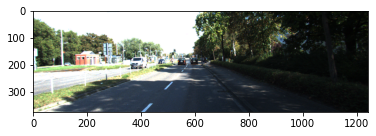

In [4]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

input_images = glob(os.path.join(dir_path, "image_2", "*.png"))
image = imread(input_images[1]) 
plt.imshow(image)
print('이미지 크기 : ',image.shape)

## Augmentation 
albumentations 라이브러리를 이용하여 augmentation진행

In [5]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                              min_max_height=(200, 360),    # 노드 (300, 370)
                              w2h_ratio=1242/375,    # 원본 이미지 배율. ***노드 370/1247
                              height=224,
                              width=224,
                              p=0.5                  # 변환을 적용할 확률 
                              ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                    Resize(
                          width=224,
                          height=224
                          )
                    ])

#### Augmentation 확인

훈련 데이터 개수 200


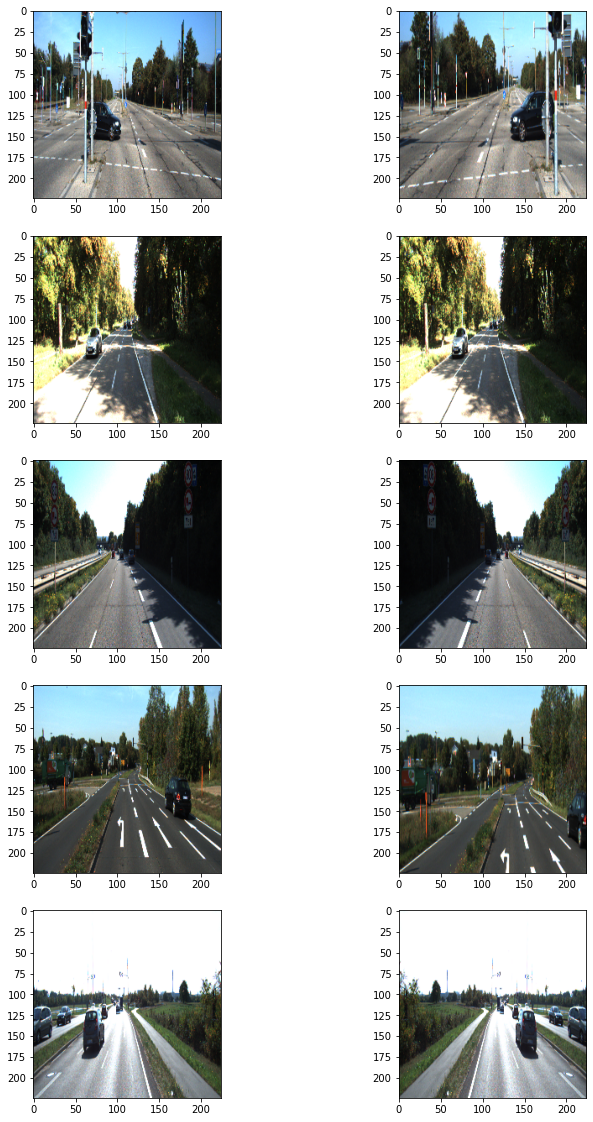

In [6]:
# dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))
print('훈련 데이터 개수',len(input_images))

# 훈련 데이터셋에서 랜덤한 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    n = np.random.randint(len(input_images))
    image = imread(input_images[n]) 
    image_data = {"image":image}
    
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

## KittiGenerator로 학습을 위한 데이터

In [7]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                   dir_path,
                   batch_size=16,
                   img_size=(224, 224, 3),
                   output_size=(224, 224),
                   is_train=True,
                   augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size 입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        # glob(dir) dir의 조건과 일치하는 파일명 전부 불러오기
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images) # 입력과 라벨의 개수가 일치하는가 확인
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30] # 훈련집합이면 뒤 30개을 제외한 170개를 return
        
        return data[-30:] # 테스트 집합은 30개

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size] # 배치 단위로 잘라준다.
        
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1 # 7번은 road 다
            data = {
                  "image": _input,
                  "mask": _output,
                  }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [8]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# U-Net
## U-Net 모델 설계

In [9]:
def encoder_block(x, fillter_n, max_pooling=True):
    enc = Conv2D(fillter_n, 3, padding='same')(x)
    enc_batch = BatchNormalization()(enc)
    enc_act = tf.keras.activations.relu(enc_batch)
    
    enc = Conv2D(fillter_n, 3, padding='same')(enc_act)
    enc_batch = BatchNormalization()(enc)
    enc_act = tf.keras.activations.relu(enc_batch)

    if max_pooling:
        pool = MaxPooling2D(pool_size=2)(enc_act)
        return pool, enc_act
    return enc_act

def decoder_block(x, skip_conn, fillter_n):
    dec = Conv2DTranspose(fillter_n,2,strides=2,padding='same')(x)
    
    conn = concatenate([dec, skip_conn], axis=3)

    dec = encoder_block(conn, fillter_n, max_pooling=False)
    return dec

def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)  

    # Encoder
    enc_1, skip_conn_1 = encoder_block(inputs, 64)
    enc_2, skip_conn_2 = encoder_block(enc_1, 128)
    enc_3, skip_conn_3 = encoder_block(enc_2, 256)
    enc_4, skip_conn_4 = encoder_block(enc_3, 512)
    enc_5 = encoder_block(enc_4, 1024, max_pooling=False)
    # Decoder
    dec_1 = decoder_block(enc_5, skip_conn_4, 512)
    dec_2 = decoder_block(dec_1, skip_conn_3, 256)
    dec_3 = decoder_block(dec_2, skip_conn_2, 128)
    dec_4 = decoder_block(dec_3, skip_conn_1, 64)

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(dec_4)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs) 
    return model

model = build_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/'

# 모델 이어서 학습
is_save_model = True
if is_save_model:
    model = tf.keras.models.load_model(model_path+'unet_150.h5')
    # # 미리 학습한 모델
    # pretrain_model_path = dir_path + '/seg_model_unet.h5' 
else:
    model = build_unet()

is_train = False
if is_train:
    model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
    model.fit(
         train_generator,
         validation_data=test_generator,
         steps_per_epoch=len(train_generator),
         epochs=50
     )

    model.save(model_path+'unet_150.h5')  #학습한 모델을 저장해 주세요.


    
    


## 결과 시각화와 IoU계산 해보기

In [11]:
def calculate_iou_score(target, prediction):
    intersection = target * prediction
    union = (target + prediction) - intersection
    iou_score = float(intersection.sum() / union.sum())
    return iou_score

In [12]:
def get_output(model, 
               preproc, 
               image_path, 
               output_path, 
               label_path, 
               threshold=0.5):
    
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=threshold).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역
        
        iou_score = calculate_iou_score(target, prediction)
        
        return output, prediction, target, iou_score
    else:
        return output, prediction, _

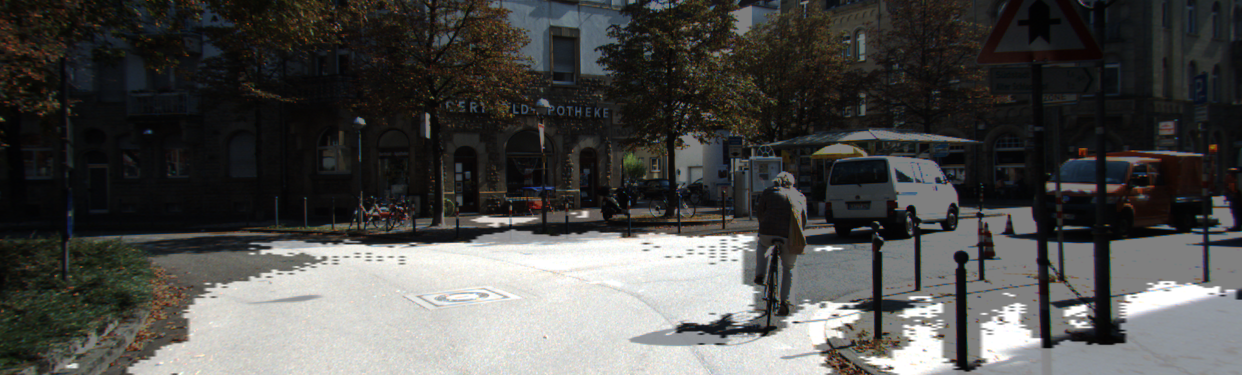

IoU : 0.602157


In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 3    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target,iou_score = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

output.show()
print('IoU : %f' % iou_score )

# U-Net++

In [14]:
def encoder_block(x, fillter_n, max_pooling=False):
    enc = Conv2D(fillter_n, 3, padding='same')(x)
    enc = BatchNormalization()(enc)
    enc = tf.keras.activations.relu(enc)
    
    enc = Conv2D(fillter_n, 3, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = tf.keras.activations.relu(enc)

    if max_pooling:
        pool = MaxPooling2D(pool_size=2)(enc)
        return enc, pool
    return enc


def build_unetpp(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)  
    
    # Encoder
    x0_0, px0_0 = encoder_block(inputs, 64, max_pooling=True)
    x1_0, px1_0 = encoder_block(px0_0, 128, max_pooling=True)
    x2_0, px2_0 = encoder_block(px1_0, 256, max_pooling=True)
    x3_0, px3_0 = encoder_block(px2_0, 512, max_pooling=True)
    
    
    # Skip conn
    ux1_0 = UpSampling2D(2)(x1_0)
    cx0_1 = concatenate([x0_0, ux1_0], axis=3)
    x0_1 = encoder_block(cx0_1, 64)
    
    ux2_0 = UpSampling2D(2)(x2_0)
    cx1_1 = concatenate([x1_0, ux2_0], axis=3)
    x1_1 = encoder_block(cx1_1, 128)
    
    ux3_0 = UpSampling2D(2)(x3_0)
    cx2_1 = concatenate([x2_0, ux3_0], axis=3)
    x2_1 = encoder_block(cx2_1, 256)
    
    ux1_1 = UpSampling2D(2)(x1_1)
    cx0_2 = concatenate([x0_0, x0_1, ux1_1], axis=3)
    x0_2 = encoder_block(cx0_2, 64)
    
    ux2_1 = UpSampling2D(2)(x2_1)
    cx1_2 = concatenate([x1_0, x1_1, ux2_1], axis=3)
    x1_2 = encoder_block(cx1_2, 128)
    
    ux1_2 = UpSampling2D(2)(x1_2)
    cx0_3 = concatenate([x0_0, x0_1, x0_2, ux1_2], axis=3)
    x0_3 = encoder_block(cx0_3, 64)
    
    
    x4_0 = encoder_block(px3_0, 1024)
    
    # Decoder
    ux4_0 = UpSampling2D(2)(x4_0)
    cx3_1 = concatenate([x3_0, ux4_0], axis=3)
    x3_1 = encoder_block(cx3_1, 512)
    
    ux3_1 = UpSampling2D(2)(x3_1)
    cx2_2 = concatenate([x2_0, x2_1, ux3_1], axis=3)
    x2_2 = encoder_block(cx2_2, 256)
    
    ux2_2 = UpSampling2D(2)(x2_2)
    cx1_3 = concatenate([x1_0, x1_1, x1_2, ux2_2], axis=3)
    x1_3 = encoder_block(cx1_3, 128)
    
    ux1_3 = UpSampling2D(2)(x1_3)
    cx0_4 = concatenate([x0_0, x0_1, x0_2, x0_3, ux1_3], axis=3)
    x0_4 = encoder_block(cx0_4, 128)
    
    
    output1 = Conv2D(1, 1, padding='same', activation='sigmoid', kernel_initializer = 'he_normal')(x0_1)
    output2 = Conv2D(1, 1, padding='same', activation='sigmoid', kernel_initializer = 'he_normal')(x0_2)
    output3 = Conv2D(1, 1, padding='same', activation='sigmoid', kernel_initializer = 'he_normal')(x0_3)
    output4 = Conv2D(1, 1, padding='same', activation='sigmoid', kernel_initializer = 'he_normal')(x0_4)
    outputs = (output1 + output2 + output3 + output4) / 4
            
    model = tf.keras.Model(inputs=inputs, outputs=outputs) 
    return model

unetpp = build_unetpp()
unetpp.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 224, 224, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
tf.nn.relu_36 (TFOpLambda)      (None, 224, 224, 64) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

* dice coefficient
True Positive를 강조한 loss기법 이라고 하네요.
간단히 식을 보면 $(\text{교집합}*2 +1 / \text{교집합 + 합집합})$

In [15]:
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [16]:
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
    batch_size=6
)
test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    batch_size=6,
    is_train=False
)

is_save_model = True
if is_save_model:
    unetpp = tf.keras.models.load_model(model_path+'unetpp_200.h5')
else:
    unetpp = build_unetpp()


is_train = False
if is_train:
    unetpp.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
    history = unetpp.fit(
                     train_generator,
                     validation_data=test_generator,
                     steps_per_epoch=len(train_generator),
                     epochs=100
                 )

    unetpp.save(model_path+'unetpp_100.h5')  #학습한 모델을 저장해 주세요.


## 결과 시각화

U-Net : Epoch 150   
U-Net++ : Epoch 200

U-Net


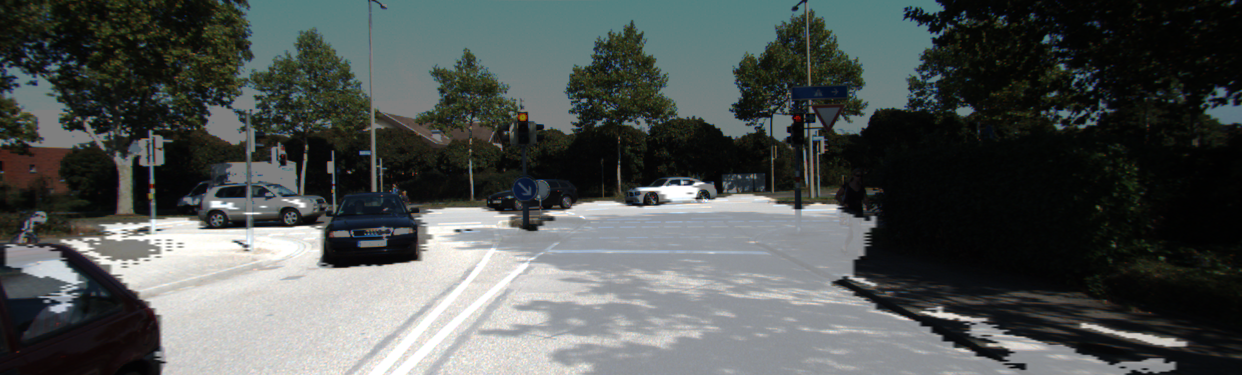

U-Net++


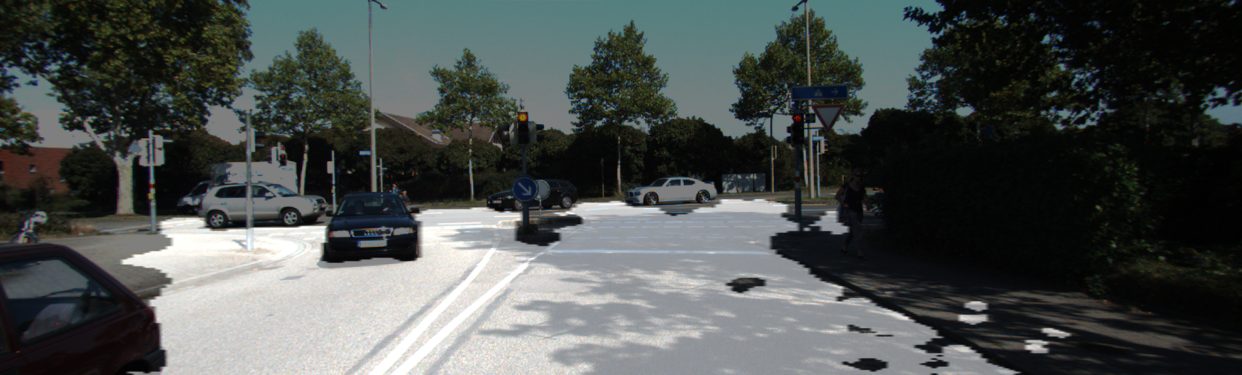

U-Net IoU : 0.794109
U-Net++ IoU : 0.877533


In [17]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 8    # i값을 바꾸면 테스트용 파일이 달라집니다. 

unet_output, prediction, target, unet_iou_score = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

unetpp_output, prediction, target, unetpp_iou_score = get_output(
     unetpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
print("U-Net")
unet_output.show()
print("U-Net++")
unetpp_output.show()

print('U-Net IoU : %f' % unet_iou_score )
print('U-Net++ IoU : %f' % unetpp_iou_score )

U-Net


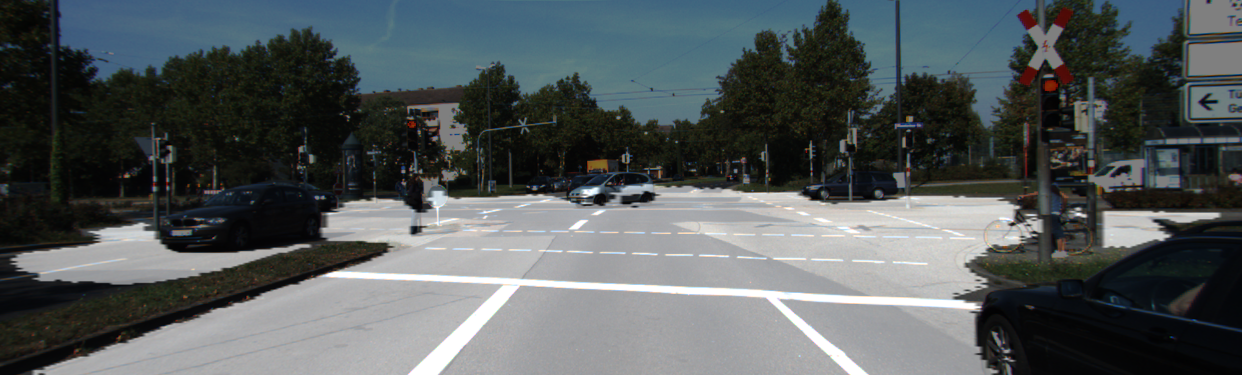

U-Net++


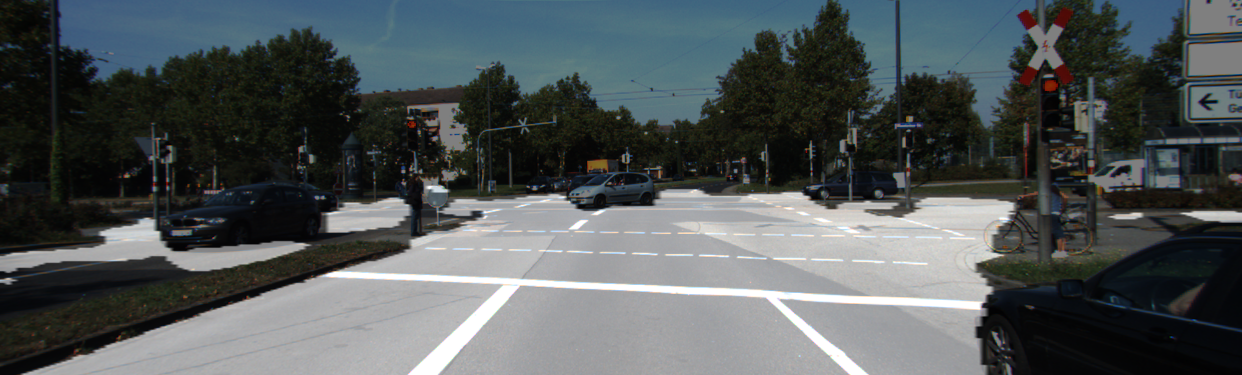

U-Net IoU : 0.904480
U-Net++ IoU : 0.882790


In [18]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 13    # i값을 바꾸면 테스트용 파일이 달라집니다. 

unet_output, prediction, target, unet_iou_score = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

unetpp_output, prediction, target, unetpp_iou_score = get_output(
     unetpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
print("U-Net")
unet_output.show()
print("U-Net++")
unetpp_output.show()

print('U-Net IoU : %f' % unet_iou_score )
print('U-Net++ IoU : %f' % unetpp_iou_score )

U-Net


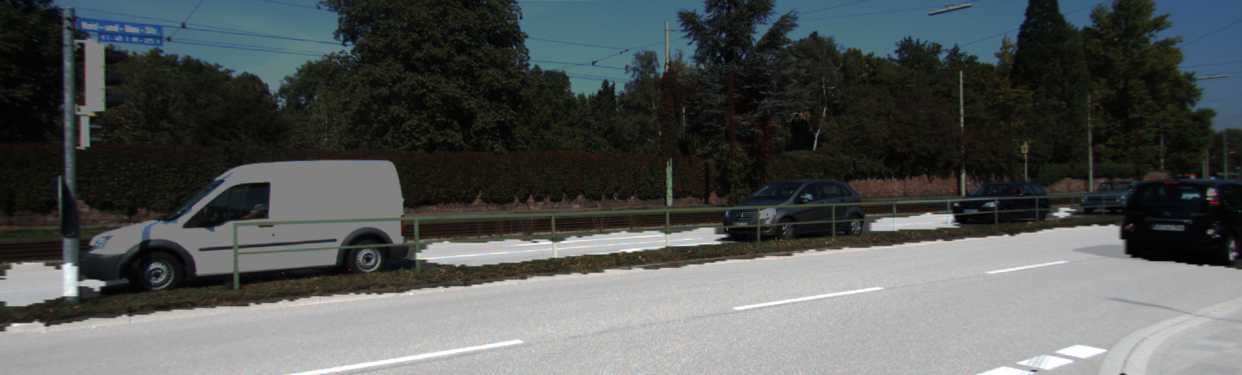

U-Net++


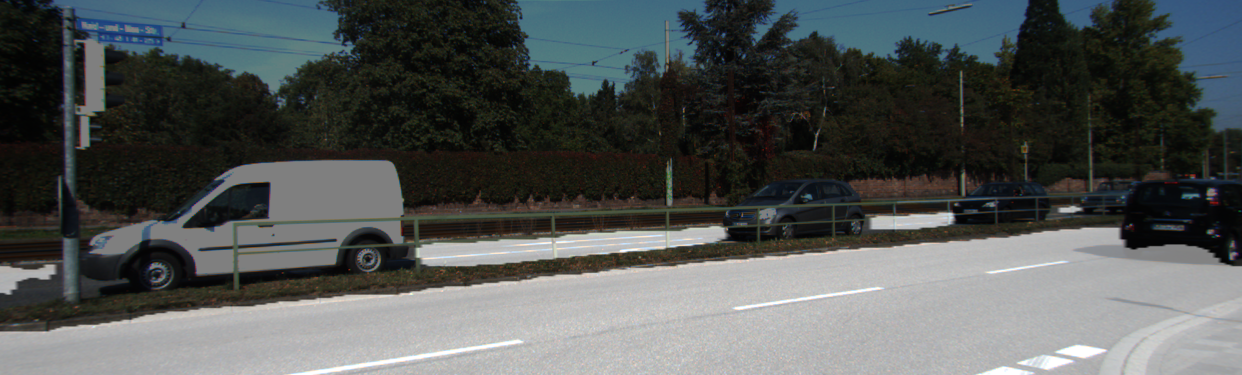

U-Net IoU : 0.862843
U-Net++ IoU : 0.863255


In [19]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 23    # i값을 바꾸면 테스트용 파일이 달라집니다. 

unet_output, prediction, target, unet_iou_score = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

unetpp_output, prediction, target, unetpp_iou_score = get_output(
     unetpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
print("U-Net")
unet_output.show()
print("U-Net++")
unetpp_output.show()

print('U-Net IoU : %f' % unet_iou_score )
print('U-Net++ IoU : %f' % unetpp_iou_score )

In [20]:
unet_iou_score = 0
unetpp_iou_score = 0
for i in range(30):
    _, _, _, iou_score = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png')
    unet_iou_score += iou_score
    
    _, _, _, iou_score = get_output(
         unetpp, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    unetpp_iou_score += iou_score

In [22]:
print('U-Net(epoch150) Mean IoU : ', (unet_iou_score/30) )
print('U-Net++(Epoch 200) Mean IoU : ', (unetpp_iou_score/30) )

U-Net(epoch150) Mean IoU :  0.7338836120191928
U-Net++(Epoch 200) Mean IoU :  0.8373837510005223


# 결과 정리

U-Net(epoch100) Mean IoU :  0.747962788117282  
U-Net++(Epoch 100) Mean IoU :  0.7503291684963636

U-Net(epoch150) Mean IoU :  0.7338836120191928   
U-Net++(Epoch 150) Mean IoU :  0.8231021105973866
 
U-Net++(Epoch 200) Mean IoU :  0.8373837510005223

|   |100epo|150epo|200epo|
|:---|:---:|:---:|:---:|
|U-Net|0.74796|0.73388|..|
|U-Net++|0.750329|0.82310|0.83738|
